# 使用CoreML训练垃圾短信过滤

## 加载模块

In [1]:
%matplotlib inline
from io import open
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
import string
plt.style.use('ggplot')
# pd.options.display.mpl_style = 'default'

## 数据

数据来源: [wandouqiang/RubbishMessage](https://github.com/wandouqiang/RubbishMessage)

In [3]:
!mkdir -p data && wget -c https://raw.githubusercontent.com/wandouqiang/RubbishMessage/master/data/80w.txt -O data/80w.txt

--2019-01-04 16:30:47--  https://raw.githubusercontent.com/wandouqiang/RubbishMessage/master/data/80w.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.72.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.72.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64501011 (62M) [text/plain]
Saving to: ‘data/80w.txt’

data/80w.txt        100%[===================>]  61.51M   663KB/s    in 2m 36s  

2019-01-04 16:33:26 (404 KB/s) - ‘data/80w.txt’ saved [64501011/64501011]



In [5]:
file_80w = './data/80w.txt'
with open(file_80w) as f:
    corpus = f.readlines()

print("共有{}条信息".format(len(corpus)))

corpus = [x.strip() for x in corpus]

for i,message in enumerate(corpus[:10]):
    print(i, message)

共有800000条信息
0 1	0	商业秘密的秘密性那是维系其商业价值和垄断地位的前提条件之一
1 2	1	南口阿玛施新春第一批限量春装到店啦         春暖花开淑女裙、冰蓝色公主衫   气质粉小西装、冰丝女王长半裙、   皇
2 3	0	带给我们大常州一场壮观的视觉盛宴
3 4	0	有原因不明的泌尿系统结石等
4 5	0	23年从盐城拉回来的麻麻的嫁妆
5 6	0	感到自减肥、跳减肥健美操、
6 7	1	感谢致电杭州萧山全金釜韩国烧烤店，本店位于金城路xxx号。韩式烧烤等，价格实惠、欢迎惠顾【全金釜韩国烧烤店】
7 8	0	这款UVe智能杀菌机器人是扫地机的最佳伴侣
8 9	1	一次价值xxx元王牌项目；可充值xxx元店内项目卡一张；可以参与V动好生活百分百抽奖机会一次！预约电话：xxxxxxxxxxx
9 10	0	此类皮肤特别容易招惹粉刺、黑头等


加载数据

In [6]:
with open(file_80w, encoding='UTF-8') as f:
    messages = pd.read_csv(f, sep='\t', quoting=csv.QUOTE_NONE, names=['label', 'message'])

messages['message'] = messages['message'].map(lambda text:text)
messages.head()

,label,message
1,0,商业秘密的秘密性那是维系其商业价值和垄断地位的前提条件之一
2,1,南口阿玛施新春第一批限量春装到店啦   春暖花开淑女裙、冰蓝色公主衫 ...
3,0,带给我们大常州一场壮观的视觉盛宴
4,0,有原因不明的泌尿系统结石等
5,0,23年从盐城拉回来的麻麻的嫁妆


In [7]:
messages.groupby('label').describe()

message                                                                
        count  unique                                                top freq
label                                                                        
0      720000  707465                                             #NAME?   61
1       80000   79146  平安易贷可帮您获取所需资金，无须抵押，手续简便快速，快来申请吧！，在申请时输入我的邀请码xx...   92

In [8]:
messages['length'] = messages['message'].map(lambda text:len(text))
messages.head()

,label,message,length
1,0,商业秘密的秘密性那是维系其商业价值和垄断地位的前提条件之一,29
2,1,南口阿玛施新春第一批限量春装到店啦   春暖花开淑女裙、冰蓝色公主衫 ...,67
3,0,带给我们大常州一场壮观的视觉盛宴,16
4,0,有原因不明的泌尿系统结石等,13
5,0,23年从盐城拉回来的麻麻的嫁妆,15


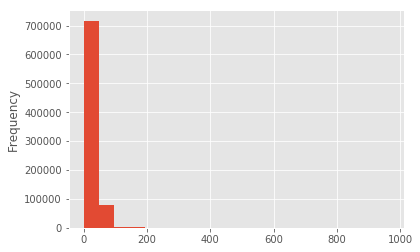

In [9]:
messages.length.plot(bins=20, kind='hist')

In [10]:
messages.length.describe()

count    800000.000000
mean         25.663336
std          19.480775
min           1.000000
25%          15.000000
50%          19.000000
75%          27.000000
max         962.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a20beab38>,
      dtype=object)

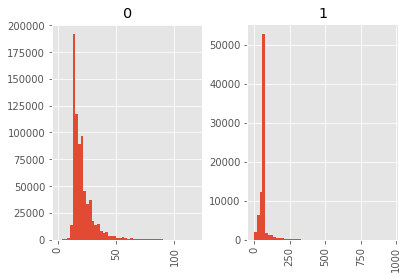

In [11]:
messages.hist(column='length', by='label', bins=50)

## 处理数据

使用 Jieba 进行分词，分词数据来源：[yanyiwu/iosjieba](https://github.com/yanyiwu/iosjieba)

In [12]:
!mkdir dict
!wget -c https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/jieba.dict.small.utf8 -O dict/jieba.dict.small.utf8
!wget -c https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/user.dict.utf8 -O dict/user.dict.utf8

--2019-01-04 16:37:29--  https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/jieba.dict.small.utf8
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.108.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1552161 (1.5M) [text/plain]
Saving to: ‘dict/jieba.dict.small.utf8’

dict/jieba.dict.sma 100%[===================>]   1.48M   543KB/s    in 2.8s    

2019-01-04 16:37:32 (543 KB/s) - ‘dict/jieba.dict.small.utf8’ saved [1552161/1552161]

--2019-01-04 16:37:32--  https://raw.githubusercontent.com/yanyiwu/iosjieba/master/iosjieba/iosjieba.bundle/dict/user.dict.utf8
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.108.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33 [text/plain]
Sa

In [14]:
print("removing punctuations: "+string.punctuation)

import jieba
jieba.set_dictionary("./dict/jieba.dict.small.utf8")
jieba.load_userdict("./dict/user.dict.utf8")
jieba.initialize()

def tokenize(message):
    """ removes punctuation and tokenizes the words and stems each word.
    """
    msg = "".join([ch for ch in message if ch not in string.punctuation]) # get rid of punctuations
    stems = list(jieba.cut(msg, HMM=True))
    return stems

messages.message.head().apply(tokenize)

Building prefix dict from /Users/qiwihui/Development/nonWork/SMSFilters/model/dict/jieba.dict.small.utf8 ...


removing punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Dumping model to file cache /var/folders/kl/g94q0k_571vdjtcwzzcv20s40000gn/T/jieba.u863e59d49beec8805b7d0b2ea2fa7f35.cache
Loading model cost 0.643 seconds.
Prefix dict has been built succesfully.


1    [商业, 秘密, 的, 秘密, 性, 那, 是, 维系, 其, 商业, 价值, 和, 垄断,...
2    [南口, 阿玛, 施, 新春, 第一批, 限量, 春装, 到, 店, 啦, ,  ,  ,...
3                   [带给, 我们, 大, 常州, 一场, 壮观, 的, 视觉, 盛宴]
4                        [有, 原因, 不明, 的, 泌尿, 系统, 结石, 等]
5                  [23, 年, 从, 盐城, 拉, 回来, 的, 麻麻, 的, 嫁妆]
Name: message, dtype: object

## 特征

特征抽取，TF-IDF

In [15]:
fv = CountVectorizer(analyzer=tokenize).fit(messages.message)

print("总词数", len(fv.vocabulary_))

列表中总词数 366750


In [16]:
print("First:")
print(fv.transform(["你好"]))

print("Second:")
print(fv.transform(["好你"]))

First:
  (0, 103421)	1
Second:
  (0, 103378)	1
  (0, 162812)	1


In [17]:
print(messages.message[3])
print(fv.transform([messages.message[3]]))

带给我们大常州一场壮观的视觉盛宴
  (0, 76144)	1
  (0, 154901)	1
  (0, 157129)	1
  (0, 182155)	1
  (0, 182558)	1
  (0, 199561)	1
  (0, 274312)	1
  (0, 275510)	1
  (0, 317302)	1


### TF

In [20]:
!mkdir -p result

In [21]:
def default(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

import json
with open('result/words_array.json', 'w') as fp:
    json.dump(fv.vocabulary_, fp, default=default)

## Messages Feature Vector

In [22]:
messages_fv = fv.transform(messages.message)
print(messages_fv.shape)

(800000, 366750)


In [23]:
tfidf = TfidfTransformer().fit(messages_fv)

# test tfidf of same message as before.
t = tfidf.transform(fv.transform([messages.message[3]]))
print(t)

  (0, 317302)	0.39779219779562225
  (0, 275510)	0.40156911498600234
  (0, 274312)	0.08158076058986856
  (0, 199561)	0.21453331213319765
  (0, 182558)	0.30040221221192215
  (0, 182155)	0.40156911498600234
  (0, 157129)	0.2305152019929351
  (0, 154901)	0.4609408713995319
  (0, 76144)	0.3327471446311214


In [24]:
messages_tfidf = tfidf.transform(messages_fv)
print(messages_tfidf.shape)

(800000, 366750)


### IDF

In [25]:
idf = {}
idf['idf'] = tfidf.idf_.tolist()

with open('result/words_idf.json', 'w') as fp:
    json.dump(idf, fp)

print("IDF of corpus :", tfidf.idf_)

IDF of corpus : [ 9.82168363 13.89922108  9.72483381 ... 13.49375597 12.0274189
  7.8577766 ]


## 模型训练

Linear SVM

In [26]:
%time spam_detector = LinearSVC().fit(messages_tfidf, messages.label)

predictions = spam_detector.predict(messages_tfidf)

print('accuracy', accuracy_score(messages['label'], predictions))
print('confusion matrix\n', confusion_matrix(messages['label'], predictions))
print('(row=expected, col=predicted)')

CPU times: user 2.64 s, sys: 256 ms, total: 2.9 s
Wall time: 2.97 s
accuracy 0.99965375
confusion matrix
 [[719972     28]
 [   249  79751]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

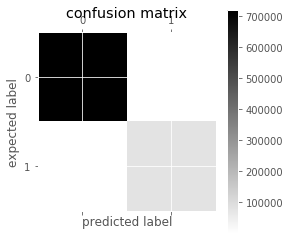

In [27]:
plt.matshow(confusion_matrix(messages['label'], predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [28]:
print(classification_report(messages['label'], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    720000
           1       1.00      1.00      1.00     80000

   micro avg       1.00      1.00      1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000



## 转换为 CoreML

In [30]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(spam_detector, "message", "spam_or_not")

#set parameters of the model
coreml_model.short_description = "Classify whether message is spam or not"
coreml_model.input_description["message"] = "TFIDF of message to be classified"
coreml_model.output_description["spam_or_not"] = "Whether message is spam or not"
#save the model
coreml_model.save("result/SpamMessageClassifier.mlmodel")

## 参考

- [Building offline iPhone spam classifier using CoreML](https://medium.com/ymedialabs-innovation/building-offline-iphone-spam-classifier-using-coreml-3552c2beb2b2)